<a href="https://colab.research.google.com/github/manhili/Machine-Learning/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Supervised Learning Project: Disease Prediction Using Random Forest Classifier**
**Case study** : *Classifying Clinical Malaria Outcumes.*

**Based on this article** : Morang’a, C.M., Amenga–Etego, L., Bah, S.Y. et al. Machine learning approaches classify clinical malaria outcomes based on haematological parameters. BMC Med 18, 375 (2020). https://doi.org/10.1186/s12916-020-01823-3

#**1. Import the libraries**

In [1]:
import pandas as pd
import numpy as np        

import matplotlib.pyplot as plt
import seaborn as sns     

import urllib.request

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import plot_tree
%matplotlib inline

# **2. Import the dataset**

In [2]:
#set urlS to the data file.
url = "https://static-content.springer.com/esm/art%3A10.1186%2Fs12916-020-01823-3/MediaObjects/12916_2020_1823_MOESM2_ESM.xlsx"

#read the data with pandas
data = pd.read_excel(url, sheet_name=0)

#**3. Exploring data**

**Number of rows and columns of the dataset.**

In [3]:
data.shape

(2207, 34)

**Have a look at the data.**

In [4]:
#view first 5 rows of the data.
data.head()

,SampleID,consent_given,location,Enrollment_Year,bednet,fever_symptom,temperature,Suspected_Organism,Suspected_infection,RDT,Blood_culture,Urine_culture,Taq_man_PCR,parasite_density,Microscopy,Laboratory_Results,Clinical_Diagnosis,wbc_count,rbc_count,hb_level,hematocrit,mean_cell_volume,mean_corp_hb,mean_cell_hb_conc,platelet_count,platelet_distr_width,mean_platelet_vl,neutrophils_percent,lymphocytes_percent,mixed_cells_percent,neutrophils_count,lymphocytes_count,mixed_cells_count,RBC_dist_width_Percent
0,CCS20043,yes,Navrongo,2004,NaN,Yes,38.0,Not Known / Missing entry,NaN,Positive,NaN,NaN,NaN,126080.0,Positive,P. falciparum,Severe Malaria,5.7,2.8,5.8,16.1,59.0,21.1,36.0,156.0,8.2,6.8,61.8,31.7,6.5,3.6,1.8,0.3,19.0
1,CCS20102,yes,Navrongo,2004,NaN,Yes,38.2,Not Known / Missing entry,NaN,Positive,NaN,NaN,NaN,149400.0,Positive,P. falciparum,Severe Malaria,7.8,3.5,9.2,24.2,70.0,26.4,37.8,55.0,16.5,7.6,68.5,23.6,7.9,5.4,1.8,0.6,14.4
2,CCS20106,yes,Navrongo,2004,NaN,Yes,37.7,Not Known / Missing entry,NaN,Positive,NaN,NaN,NaN,5880.0,Positive,P. falciparum,Severe Malaria,8.2,1.0,2.3,5.7,59.0,23.8,40.4,20.0,2.3,5.9,32.8,53.3,13.9,2.8,4.3,1.1,18.0
3,CCS20147,yes,Navrongo,2004,NaN,Yes,37.7,Not Known / Missing entry,NaN,Positive,NaN,NaN,NaN,85000.0,Positive,P. falciparum,Severe Malaria,15.9,3.3,10.1,25.1,75.0,30.2,40.2,132.0,17.2,6.2,82.6,11.5,5.9,13.2,1.8,0.9,13.7
4,CCS20170,yes,Navrongo,2004,NaN,Yes,37.1,Not Known / Missing entry,NaN,Positive,NaN,NaN,NaN,149760.0,Positive,P. falciparum,Severe Malaria,4.5,2.1,5.7,16.1,78.0,27.1,35.4,85.0,16.1,6.8,83.7,11.3,5.0,3.8,0.5,0.2,15.0


In [5]:
# Get informations about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SampleID                2207 non-null   object 
 1   consent_given           2207 non-null   object 
 2   location                2207 non-null   object 
 3   Enrollment_Year         2207 non-null   int64  
 4   bednet                  1676 non-null   object 
 5   fever_symptom           2200 non-null   object 
 6   temperature             2197 non-null   float64
 7   Suspected_Organism      2207 non-null   object 
 8   Suspected_infection     1569 non-null   object 
 9   RDT                     2065 non-null   object 
 10  Blood_culture           122 non-null    object 
 11  Urine_culture           112 non-null    object 
 12  Taq_man_PCR             176 non-null    object 
 13  parasite_density        2173 non-null   float64
 14  Microscopy              2170 non-null   

**Subset data**

In [6]:
#Keep features 'Clinical diagnosis' up to 'RBC dist width Percent'
#meaning we will subset the data from column 16 - the last column
subset = data.iloc[:,16:]

In [7]:
subset.shape

(2207, 18)

In [8]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Clinical_Diagnosis      2207 non-null   object 
 1   wbc_count               2207 non-null   float64
 2   rbc_count               2207 non-null   float64
 3   hb_level                2207 non-null   float64
 4   hematocrit              2207 non-null   float64
 5   mean_cell_volume        2207 non-null   float64
 6   mean_corp_hb            2204 non-null   float64
 7   mean_cell_hb_conc       2205 non-null   float64
 8   platelet_count          2198 non-null   float64
 9   platelet_distr_width    2175 non-null   float64
 10  mean_platelet_vl        2190 non-null   float64
 11  neutrophils_percent     2207 non-null   float64
 12  lymphocytes_percent     2207 non-null   float64
 13  mixed_cells_percent     2207 non-null   float64
 14  neutrophils_count       2195 non-null   

In [9]:
subset.head()

,Clinical_Diagnosis,wbc_count,rbc_count,hb_level,hematocrit,mean_cell_volume,mean_corp_hb,mean_cell_hb_conc,platelet_count,platelet_distr_width,mean_platelet_vl,neutrophils_percent,lymphocytes_percent,mixed_cells_percent,neutrophils_count,lymphocytes_count,mixed_cells_count,RBC_dist_width_Percent
0,Severe Malaria,5.7,2.8,5.8,16.1,59.0,21.1,36.0,156.0,8.2,6.8,61.8,31.7,6.5,3.6,1.8,0.3,19.0
1,Severe Malaria,7.8,3.5,9.2,24.2,70.0,26.4,37.8,55.0,16.5,7.6,68.5,23.6,7.9,5.4,1.8,0.6,14.4
2,Severe Malaria,8.2,1.0,2.3,5.7,59.0,23.8,40.4,20.0,2.3,5.9,32.8,53.3,13.9,2.8,4.3,1.1,18.0
3,Severe Malaria,15.9,3.3,10.1,25.1,75.0,30.2,40.2,132.0,17.2,6.2,82.6,11.5,5.9,13.2,1.8,0.9,13.7
4,Severe Malaria,4.5,2.1,5.7,16.1,78.0,27.1,35.4,85.0,16.1,6.8,83.7,11.3,5.0,3.8,0.5,0.2,15.0


**Handling missing values**

In [10]:
#get the number of missing values for each column.
subset.isnull().sum()

Clinical_Diagnosis         0
wbc_count                  0
rbc_count                  0
hb_level                   0
hematocrit                 0
mean_cell_volume           0
mean_corp_hb               3
mean_cell_hb_conc          2
platelet_count             9
platelet_distr_width      32
mean_platelet_vl          17
neutrophils_percent        0
lymphocytes_percent        0
mixed_cells_percent        0
neutrophils_count         12
lymphocytes_count         11
mixed_cells_count         11
RBC_dist_width_Percent     9
dtype: int64

In [11]:
subset.dropna(inplace=True)

In [12]:
subset.shape

(2156, 18)

**Identify the different classes of our categorical variable : "Clinical_Diagnosis"**

In [13]:
subset['Clinical_Diagnosis'].unique()

array(['Severe Malaria', 'Uncomplicated Malaria', 'Non-malaria Infection'],
      dtype=object)

In [14]:
labels = pd.Categorical(subset['Clinical_Diagnosis'])
labels

['Severe Malaria', 'Severe Malaria', 'Severe Malaria', 'Severe Malaria', 'Severe Malaria', ..., 'Uncomplicated Malaria', 'Non-malaria Infection', 'Non-malaria Infection', 'Non-malaria Infection', 'Non-malaria Infection']
Length: 2156
Categories (3, object): ['Non-malaria Infection', 'Severe Malaria', 'Uncomplicated Malaria']

In [15]:
subset.head()

,Clinical_Diagnosis,wbc_count,rbc_count,hb_level,hematocrit,mean_cell_volume,mean_corp_hb,mean_cell_hb_conc,platelet_count,platelet_distr_width,mean_platelet_vl,neutrophils_percent,lymphocytes_percent,mixed_cells_percent,neutrophils_count,lymphocytes_count,mixed_cells_count,RBC_dist_width_Percent
0,Severe Malaria,5.7,2.8,5.8,16.1,59.0,21.1,36.0,156.0,8.2,6.8,61.8,31.7,6.5,3.6,1.8,0.3,19.0
1,Severe Malaria,7.8,3.5,9.2,24.2,70.0,26.4,37.8,55.0,16.5,7.6,68.5,23.6,7.9,5.4,1.8,0.6,14.4
2,Severe Malaria,8.2,1.0,2.3,5.7,59.0,23.8,40.4,20.0,2.3,5.9,32.8,53.3,13.9,2.8,4.3,1.1,18.0
3,Severe Malaria,15.9,3.3,10.1,25.1,75.0,30.2,40.2,132.0,17.2,6.2,82.6,11.5,5.9,13.2,1.8,0.9,13.7
4,Severe Malaria,4.5,2.1,5.7,16.1,78.0,27.1,35.4,85.0,16.1,6.8,83.7,11.3,5.0,3.8,0.5,0.2,15.0


In [16]:
#calculate the number of observations for each category
subset['Clinical_Diagnosis'].value_counts()

Non-malaria Infection    966
Uncomplicated Malaria    702
Severe Malaria           488
Name: Clinical_Diagnosis, dtype: int64

**Class distribution**

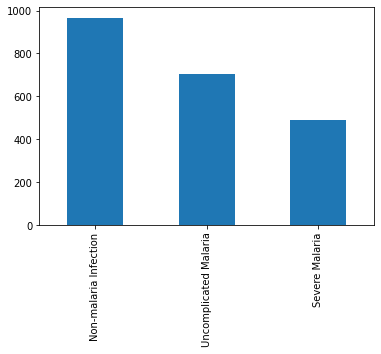

In [17]:
subset['Clinical_Diagnosis'].value_counts().plot.bar()

In [18]:
#descriptive statistics
subset.iloc[:,1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wbc_count,2156.0,10.723516,5.944994,0.5,6.80,9.30,12.900,53.90
rbc_count,2156.0,3.911679,1.132454,0.5,3.34,4.17,4.650,6.67
hb_level,2156.0,9.423010,2.650261,1.4,7.90,10.20,11.325,18.70
hematocrit,2156.0,29.320223,8.802975,4.3,24.20,31.70,35.500,52.70
mean_cell_volume,2156.0,74.828256,8.046383,7.8,70.00,75.00,80.000,121.00
mean_corp_hb,2156.0,24.142189,3.203595,2.1,22.20,24.10,26.200,38.80
mean_cell_hb_conc,2156.0,32.259318,2.864637,15.7,30.60,32.10,33.425,46.60
platelet_count,2156.0,214.545176,128.697718,3.0,105.00,201.00,300.250,1087.00
platelet_distr_width,2156.0,14.137894,3.064643,0.0,12.90,14.90,15.600,23.90
mean_platelet_vl,2156.0,8.031447,1.194886,3.3,7.20,7.90,8.800,18.60


**Checking for correlation between features**

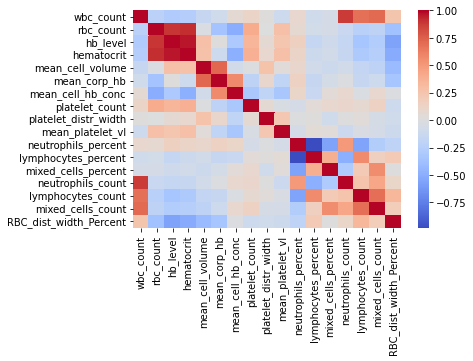

In [19]:

sns.heatmap(subset.corr(),cmap='coolwarm')

#**4. Data Preprocessing**

In [20]:
# Putting Feature Variable to X and Target variable to y
X = subset.iloc[:,1:]
y = subset.iloc[:,0]

**Encoding labels**

In [21]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

In [22]:
classes = label_encoder.classes_
print(classes)

['Non-malaria Infection' 'Severe Malaria' 'Uncomplicated Malaria']


#**5. Split data into train and test sets**

In [23]:
# 80% of the data for traning and 20% for the test 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2)

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1724, 17), (1724,), (432, 17), (432,))

#**6. Training phase**

In [26]:
# training data using Random Forest Classifier
RF = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

In [27]:
%%time
RF.fit(X_train, y_train)

CPU times: user 489 ms, sys: 55.2 ms, total: 544 ms
Wall time: 411 ms


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [28]:
# checking the oob score
RF.oob_score_

0.8149651972157773

#**7. Hyperparameter tuning**

In [29]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [30]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [31]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [32]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits
CPU times: user 5.51 s, sys: 316 ms, total: 5.83 s
Wall time: 2min 30s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [33]:
grid_search.best_score_

0.8172853828306265

In [34]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)

From hyperparameter tuning, the best set of parameters identified were :

*   max_depth = **10**
*   min_samples_leaf = **5**
*   n_estimators = **200** 



#**8. Visualization**

[Text(1320.304090909091, 2075.5636363636363, 'rbc_count <= 3.305\ngini = 0.638\nsamples = 1092\nvalue = [775, 361, 588]\nclass = Non-malaria Infection'),
 Text(436.2545454545455, 1877.8909090909092, 'mean_platelet_vl <= 7.45\ngini = 0.422\nsamples = 269\nvalue = [18, 303, 99]\nclass = Severe Malaria'),
 Text(178.56, 1680.2181818181818, 'hb_level <= 6.15\ngini = 0.163\nsamples = 157\nvalue = [4, 227, 18]\nclass = Severe Malaria'),
 Text(64.9309090909091, 1482.5454545454545, 'platelet_count <= 276.0\ngini = 0.012\nsamples = 103\nvalue = [1, 160, 0]\nclass = Severe Malaria'),
 Text(32.46545454545455, 1284.8727272727274, 'gini = 0.0\nsamples = 85\nvalue = [0, 134, 0]\nclass = Severe Malaria'),
 Text(97.39636363636365, 1284.8727272727274, 'hematocrit <= 14.2\ngini = 0.071\nsamples = 18\nvalue = [1, 26, 0]\nclass = Severe Malaria'),
 Text(64.9309090909091, 1087.2, 'gini = 0.0\nsamples = 13\nvalue = [0, 22, 0]\nclass = Severe Malaria'),
 Text(129.8618181818182, 1087.2, 'gini = 0.32\nsamples =

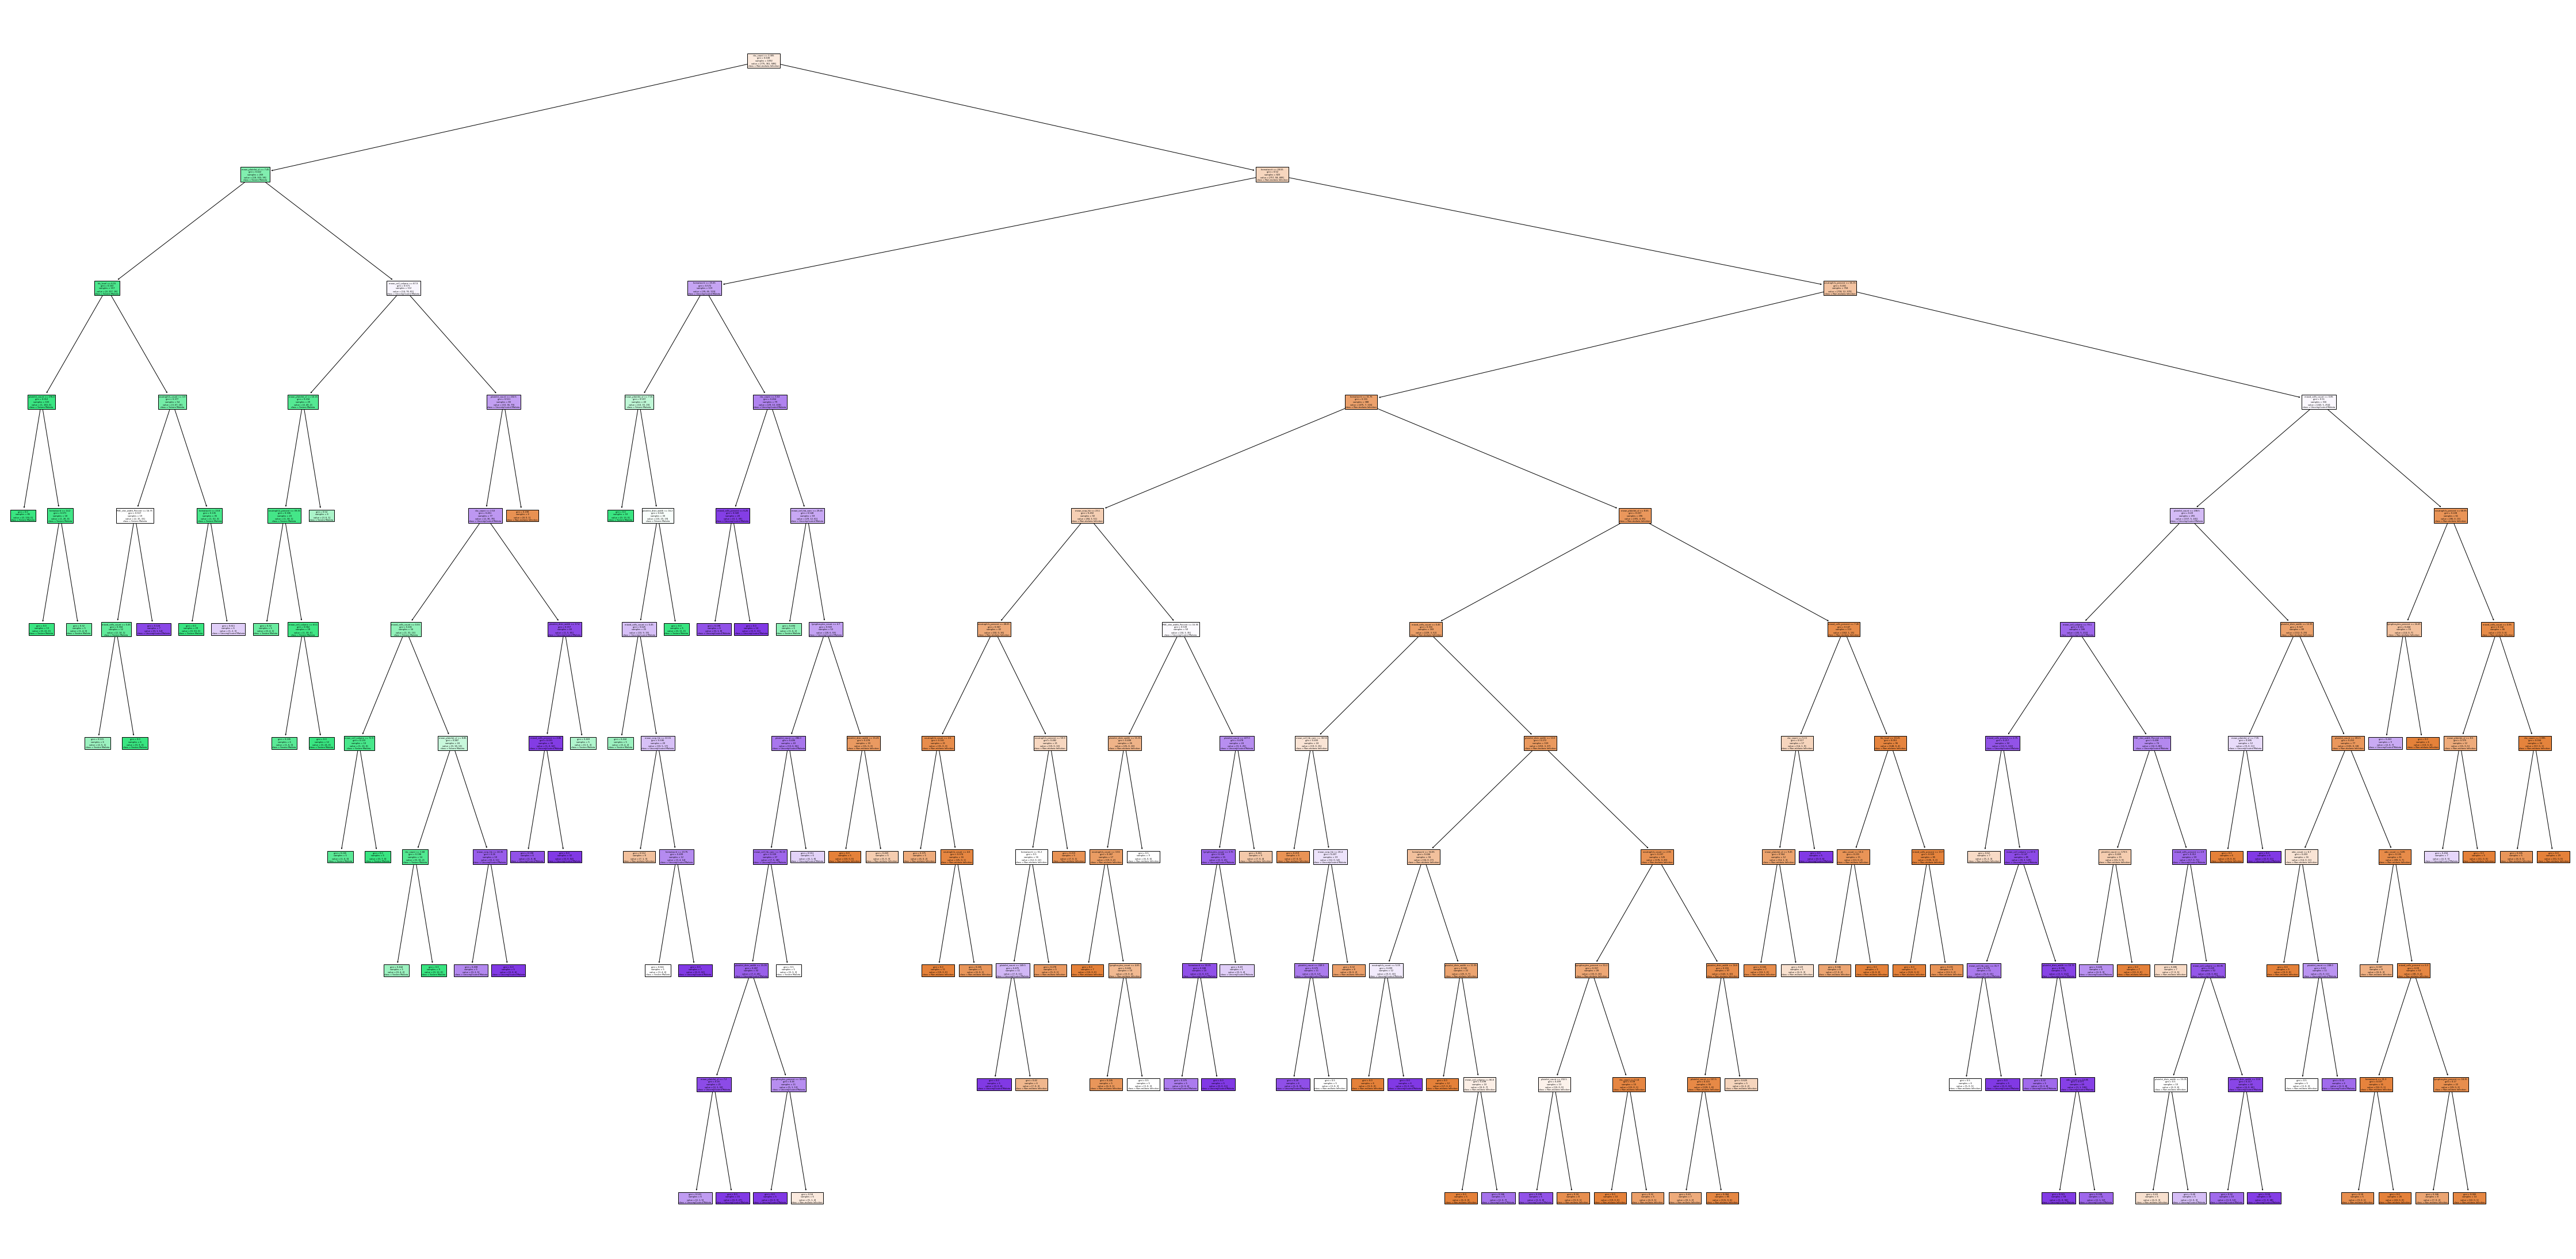

In [35]:
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns, class_names=classes, filled=True)
#plt.savefig("RF.pdf")

#**9. Testing phase**

In [36]:
predictions = rf_best.predict(X_test)

In [37]:
predictions[0:3]

array([1, 0, 0])

In [38]:
y_test[0:3]

array([1, 0, 0])

In [39]:
classes

array(['Non-malaria Infection', 'Severe Malaria', 'Uncomplicated Malaria'],
      dtype=object)

#**10. Evaluating the model**

**Balanced accuracy**

In [40]:
balanced_accuracy=balanced_accuracy_score(y_test, predictions)
balanced_accuracy=round(balanced_accuracy,2)
print('balanced accuracy:',balanced_accuracy)

balanced accuracy: 0.83


**F1 Score**

In [41]:
f1score = f1_score(y_test, predictions, average='weighted')
f1score = round(f1score, 2)
print('F1-Score:', f1score)

F1-Score: 0.84


**Precision**

In [42]:
precision = precision_score(y_test, predictions, average='weighted')
precision = round(precision, 2)
print('precision:', precision)

precision: 0.84


**Recall**

In [43]:
recall = recall_score(y_test, predictions, average='weighted')
recall = round(recall, 2)
print('recall:', recall)

recall: 0.84


**Confusion matrix**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


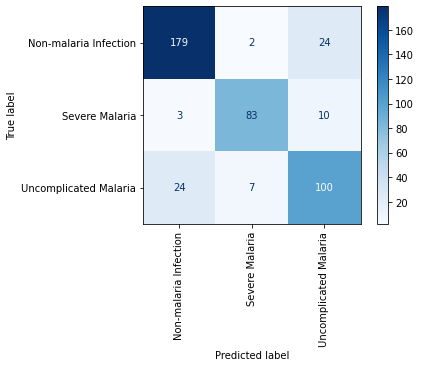

In [44]:
#confusion matrix
disp=plot_confusion_matrix(rf_best,X_test,y_test,xticks_rotation='vertical',
                     cmap='Blues',display_labels=classes)


#**11. Feature importance**

Let's sort the data with the help of feature importance.

In [45]:
rf_best.feature_importances_

array([0.01790355, 0.10220447, 0.13609673, 0.14994893, 0.02333794,
       0.02015125, 0.06986747, 0.17360604, 0.0558317 , 0.05702084,
       0.03224115, 0.02809773, 0.02451472, 0.01652086, 0.04009675,
       0.02134223, 0.03121762])

In [46]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_best.feature_importances_
})

In [47]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
7,platelet_count,0.173606
3,hematocrit,0.149949
2,hb_level,0.136097
1,rbc_count,0.102204
6,mean_cell_hb_conc,0.069867
9,mean_platelet_vl,0.057021
8,platelet_distr_width,0.055832
14,lymphocytes_count,0.040097
10,neutrophils_percent,0.032241
16,RBC_dist_width_Percent,0.031218


In [48]:
import time

start_time = time.time()
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.108 seconds


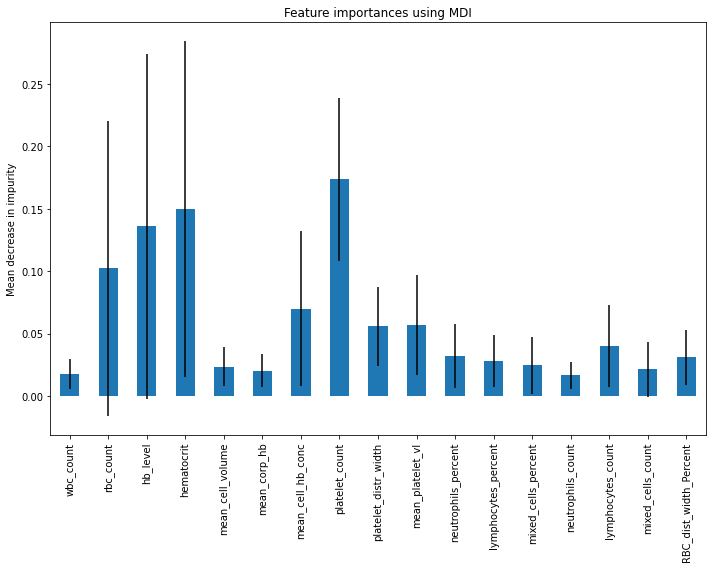

In [49]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
